In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import date
from pandas import DataFrame
warnings.filterwarnings('ignore')
%matplotlib inline 
sns.set(color_codes=True)
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, rand_score
from sklearn.decomposition import PCA
from sklearn import metrics

In [2]:
delitos_2020 = pd.read_csv('delitos_2020.csv')
delitos_2019 = pd.read_csv('delitos_2019.csv')

In [3]:
delitos_2020.dtypes

id_mapa       object
anio           int64
mes           object
dia           object
fecha         object
franja        object
tipo          object
subtipo       object
uso_armas     object
barrio        object
comuna       float64
latitud      float64
longitud     float64
victimas     float64
dtype: object

In [4]:
delitos_2019.dtypes

id                       int64
fecha                   object
franja_horaria          object
tipo_delito             object
subtipo_delito          object
cantidad_registrada    float64
comuna                 float64
barrio                  object
lat                    float64
long                   float64
dtype: object

In [5]:
print(f'Shape: {np.shape(delitos_2020)}')
delitos_2020.head(3)

Shape: (66714, 14)


,id_mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_armas,barrio,comuna,latitud,longitud,victimas
0,HC-2020-0007157,2020,Enero,Sábado,04/01/2020,10,Homicidio,Siniestro Vial,NaN,Villa Crespo,15.0,-34.592133,-58.439106,1.0
1,HC-2020-0009055,2020,Enero,Domingo,05/01/2020,20,Homicidio,Siniestro Vial,NaN,Flores,7.0,-34.646459,-58.450195,1.0
2,HC-2020-0022499,2020,Enero,Sábado,11/01/2020,6,Homicidio,Siniestro Vial,NaN,Balvanera,3.0,-34.609272,-58.393379,1.0


In [6]:
print(f'Shape: {np.shape(delitos_2019)}')
delitos_2019.head(3)

Shape: (122484, 10)


,id,fecha,franja_horaria,tipo_delito,subtipo_delito,cantidad_registrada,comuna,barrio,lat,long
0,1038983,13-09-19,14,Robo (con violencia),NaN,NaN,6.0,Caballito,-34.609876,-58.456159
1,1038986,13-09-19,16,Robo (con violencia),NaN,NaN,3.0,Balvanera,-34.609394,-58.395934
2,1038989,13-09-19,13,Robo (con violencia),NaN,NaN,3.0,Balvanera,-34.609231,-58.411177


Renombramos columnas para luego poder concatenar ambos Datasets en uno solo.

In [7]:
delitos_2020 = delitos_2020.rename(columns={'franja':'franja_horaria'})

In [8]:
delitos_2019 = delitos_2019.rename(columns={'tipo_delito':'tipo',
                                           'subtipo_delito':'subtipo',
                                           'lat':'latitud',
                                           'long':'longitud',
                                           'cantidad_registrada':'victimas'})

In [9]:
delitos_total = pd.concat([delitos_2020,delitos_2019],
                                  axis = 0, 
                                  join = "inner", 
                                  ignore_index = False)
delitos_total.head(-3)

,fecha,franja_horaria,tipo,subtipo,barrio,comuna,latitud,longitud,victimas
0,04/01/2020,10,Homicidio,Siniestro Vial,Villa Crespo,15.0,-34.592133,-58.439106,1.0
1,05/01/2020,20,Homicidio,Siniestro Vial,Flores,7.0,-34.646459,-58.450195,1.0
2,11/01/2020,6,Homicidio,Siniestro Vial,Balvanera,3.0,-34.609272,-58.393379,1.0
3,14/01/2020,6,Homicidio,Siniestro Vial,San Cristóbal,3.0,-34.624766,-58.410372,1.0
4,14/01/2020,21,Homicidio,Siniestro Vial,Monserrat,1.0,-34.609303,-58.390526,1.0
...,...,...,...,...,...,...,...,...,...
122476,13-09-19,21,Robo (con violencia),NaN,Caballito,6.0,-34.613917,-58.440915,NaN
122477,13-09-19,4,Robo (con violencia),NaN,Balvanera,3.0,-34.613823,-58.391717,NaN
122478,13-09-19,9,Robo (con violencia),NaN,San Cristóbal,3.0,-34.622990,-58.401106,NaN
122479,13-09-19,21,Robo (con violencia),NaN,Vélez Sársfield,10.0,-34.631202,-58.500760,NaN


In [10]:
#Veremos el porcentaje de nulos que tiene cada columna
total_na = ((delitos_total.isnull().sum() / len(delitos_total))*100).sort_values(ascending = False)
print(total_na)

victimas          94.453430
subtipo           89.477690
barrio             0.582987
comuna             0.582987
latitud            0.582987
longitud           0.582987
fecha              0.000000
franja_horaria     0.000000
tipo               0.000000
dtype: float64


Eliminaremos las columnas victimas y subtipo ya que en su mayoría están compuestas por nulos. Además, eliminaremos los registros que tengan nulos en barrio, comuna, latitud y longitud.

In [11]:
delitos_total.drop(['victimas', 'subtipo'], axis = 'columns', inplace=True)
delitos_total.head(-3)

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud
0,04/01/2020,10,Homicidio,Villa Crespo,15.0,-34.592133,-58.439106
1,05/01/2020,20,Homicidio,Flores,7.0,-34.646459,-58.450195
2,11/01/2020,6,Homicidio,Balvanera,3.0,-34.609272,-58.393379
3,14/01/2020,6,Homicidio,San Cristóbal,3.0,-34.624766,-58.410372
4,14/01/2020,21,Homicidio,Monserrat,1.0,-34.609303,-58.390526
...,...,...,...,...,...,...,...
122476,13-09-19,21,Robo (con violencia),Caballito,6.0,-34.613917,-58.440915
122477,13-09-19,4,Robo (con violencia),Balvanera,3.0,-34.613823,-58.391717
122478,13-09-19,9,Robo (con violencia),San Cristóbal,3.0,-34.622990,-58.401106
122479,13-09-19,21,Robo (con violencia),Vélez Sársfield,10.0,-34.631202,-58.500760


In [12]:
delitos_total = delitos_total[delitos_total['barrio'].notna()]

In [13]:
total_na = ((delitos_total.isnull().sum() / len(delitos_total))*100).sort_values(ascending = False)
print(total_na)

fecha             0.0
franja_horaria    0.0
tipo              0.0
barrio            0.0
comuna            0.0
latitud           0.0
longitud          0.0
dtype: float64


Quitaremos los duplicados debido a que un mismo delito no debería estar cargado dos veces en el Dataset. Asimismo, efectuaremos cambios (como caracteres, tipos de datos) que nos permitan conseguir homogeneidad en los datos.

In [14]:
delitos_total.drop_duplicates(inplace=True,keep='first')
print(f'Shape: {np.shape(delitos_total)}')

Shape: (186930, 7)


In [15]:
delitos_total.fecha = delitos_total['fecha'].replace("-", "/", regex=True)
delitos_total.fecha = delitos_total['fecha'].replace("/19","/2019",regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("á", "A", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("é", "E", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("í", "I", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("ó", "O", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("ú", "U", regex=True)
delitos_total['barrio'] = delitos_total['barrio'].str.upper()

In [16]:
delitos_total.head(-3)

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud
0,04/01/2020,10,Homicidio,VILLA CRESPO,15.0,-34.592133,-58.439106
1,05/01/2020,20,Homicidio,FLORES,7.0,-34.646459,-58.450195
2,11/01/2020,6,Homicidio,BALVANERA,3.0,-34.609272,-58.393379
3,14/01/2020,6,Homicidio,SAN CRISTOBAL,3.0,-34.624766,-58.410372
4,14/01/2020,21,Homicidio,MONSERRAT,1.0,-34.609303,-58.390526
...,...,...,...,...,...,...,...
122476,13/09/2019,21,Robo (con violencia),CABALLITO,6.0,-34.613917,-58.440915
122477,13/09/2019,4,Robo (con violencia),BALVANERA,3.0,-34.613823,-58.391717
122478,13/09/2019,9,Robo (con violencia),SAN CRISTOBAL,3.0,-34.622990,-58.401106
122479,13/09/2019,21,Robo (con violencia),VELEZ SARSFIELD,10.0,-34.631202,-58.500760


In [17]:
delitos_total = delitos_total.reset_index()

In [18]:
delitos_total.drop(['index'], axis = 'columns', inplace=True)
delitos_total.head(-3)

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud
0,04/01/2020,10,Homicidio,VILLA CRESPO,15.0,-34.592133,-58.439106
1,05/01/2020,20,Homicidio,FLORES,7.0,-34.646459,-58.450195
2,11/01/2020,6,Homicidio,BALVANERA,3.0,-34.609272,-58.393379
3,14/01/2020,6,Homicidio,SAN CRISTOBAL,3.0,-34.624766,-58.410372
4,14/01/2020,21,Homicidio,MONSERRAT,1.0,-34.609303,-58.390526
...,...,...,...,...,...,...,...
186922,13/09/2019,21,Robo (con violencia),CABALLITO,6.0,-34.613917,-58.440915
186923,13/09/2019,4,Robo (con violencia),BALVANERA,3.0,-34.613823,-58.391717
186924,13/09/2019,9,Robo (con violencia),SAN CRISTOBAL,3.0,-34.622990,-58.401106
186925,13/09/2019,21,Robo (con violencia),VELEZ SARSFIELD,10.0,-34.631202,-58.500760


In [19]:
delitos_total.dtypes

fecha              object
franja_horaria     object
tipo               object
barrio             object
comuna            float64
latitud           float64
longitud          float64
dtype: object

In [20]:
delitos_total["franja_horaria"].unique()

array(['10', '20', '6', '21', '12', '0', '7', '5', '11', '2', '14', '13',
       '23', '17', '16', '8', '15', '3', '18', '4', '19', '1', '22', '9',
       'SD', 'sd', 12, 8, 10, 23, 17, 9, 15, 7, 11, 22, 3, 14, 20, 1, 18,
       6, 0, 5, 13, 19, 21, 16, 4, 2, 'S/D'], dtype=object)

In [21]:
delitos_total = delitos_total.astype({"franja_horaria": str})

In [22]:
SD = delitos_total["franja_horaria"].value_counts()
print(SD)

0      12166
18     11036
19     10996
20     10765
12     10218
17     10044
16      9933
14      9854
15      9522
21      9454
13      9320
10      8905
11      8864
22      8090
9       7919
8       7806
23      6602
7       5597
6       4303
1       3679
5       3408
2       2838
4       2579
3       2546
SD       481
S/D        4
sd         1
Name: franja_horaria, dtype: int64


In [23]:
delitos_total = delitos_total.drop(delitos_total[delitos_total['franja_horaria']=="sd"].index)
delitos_total = delitos_total.drop(delitos_total[delitos_total['franja_horaria']=="S/D"].index)
delitos_total = delitos_total.drop(delitos_total[delitos_total['franja_horaria']=="SD"].index)
SD = delitos_total["franja_horaria"].value_counts()
print(SD)

0     12166
18    11036
19    10996
20    10765
12    10218
17    10044
16     9933
14     9854
15     9522
21     9454
13     9320
10     8905
11     8864
22     8090
9      7919
8      7806
23     6602
7      5597
6      4303
1      3679
5      3408
2      2838
4      2579
3      2546
Name: franja_horaria, dtype: int64


Creamos las columnas de mes y año para utilizarlas, posteriormente, en varios gráficos.

In [24]:
delitos_total['mesaño'] = delitos_total['fecha'].str[3:]
delitos_total['mes'] = delitos_total['fecha'].str[3:5]
delitos_total['dia'] = delitos_total['fecha'].str[8:]
delitos_total = delitos_total.sort_values(by='mesaño') 

In [25]:
delitos_total['año'] = delitos_total['fecha'].str[6:]
delitos_total = delitos_total.astype({"franja_horaria": int})
delitos_total = delitos_total.astype({"comuna": int})
#delitos_total = delitos_total['tipo'].astype('str')

delitos_total.dtypes

fecha              object
franja_horaria      int64
tipo               object
barrio             object
comuna              int64
latitud           float64
longitud          float64
mesaño             object
mes                object
dia                object
año                object
dtype: object

In [26]:
delitos_total.head()

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud,mesaño,mes,dia,año
81926,25/01/2019,11,Robo (con violencia),PARQUE PATRICIOS,4,-34.636791,-58.403786,01/2019,01,19,2019
71939,18/01/2019,8,Robo (con violencia),RECOLETA,2,-34.592514,-58.404175,01/2019,01,19,2019
71940,18/01/2019,15,Robo (con violencia),CHACARITA,15,-34.590628,-58.448602,01/2019,01,19,2019
71941,18/01/2019,2,Robo (con violencia),PARQUE CHAS,15,-34.588924,-58.478135,01/2019,01,19,2019
71942,18/01/2019,2,Robo (con violencia),PARQUE CHAS,15,-34.588848,-58.484470,01/2019,01,19,2019


In [27]:
delitos_total['fecha'] = pd.to_datetime(delitos_total['fecha'], format="%d/%m/%Y")

In [28]:
delitos_total.loc[(delitos_total['tipo'] == 'Homicidio', 'gravedad')] = 4
delitos_total.loc[(delitos_total['tipo'] == 'Lesiones', 'gravedad')]  = 3
delitos_total.loc[(delitos_total['tipo'] == 'Robo (con violencia)', 'gravedad')] = 2
delitos_total.loc[(delitos_total['tipo'] == 'Hurto (sin violencia)','gravedad')]  = 1


In [29]:
delitos_total.head()

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud,mesaño,mes,dia,año,gravedad
81926,2019-01-25,11,Robo (con violencia),PARQUE PATRICIOS,4,-34.636791,-58.403786,01/2019,01,19,2019,2.0
71939,2019-01-18,8,Robo (con violencia),RECOLETA,2,-34.592514,-58.404175,01/2019,01,19,2019,2.0
71940,2019-01-18,15,Robo (con violencia),CHACARITA,15,-34.590628,-58.448602,01/2019,01,19,2019,2.0
71941,2019-01-18,2,Robo (con violencia),PARQUE CHAS,15,-34.588924,-58.478135,01/2019,01,19,2019,2.0
71942,2019-01-18,2,Robo (con violencia),PARQUE CHAS,15,-34.588848,-58.484470,01/2019,01,19,2019,2.0


In [30]:
barrios = pd.read_csv('pob_barrios.csv')

In [31]:
barrios.head()

,BARRIO,POBLACION
0,AGRONOMIA,13912
1,ALMAGRO,131699
2,BALVANERA,138926
3,BARRACAS,89452
4,BELGRANO,126267


In [32]:
dxbarrio = delitos_total.barrio.value_counts()
dxbarrio = dxbarrio.reset_index()
dxbarrio = pd.DataFrame(dxbarrio)

In [33]:
dxbarrio = dxbarrio.rename(columns={'index':'BARRIO','barrio':'delitos por barrio'})
dxbarrio.head()

,BARRIO,delitos por barrio
0,PALERMO,15223
1,BALVANERA,13848
2,FLORES,9064
3,RECOLETA,8750
4,SAN NICOLAS,8342


In [34]:
dens_pob = pd.merge(barrios, dxbarrio, how='outer', left_on=barrios['BARRIO'], right_on=dxbarrio['BARRIO'])
dens_pob['Densidad delitos'] = dens_pob['delitos por barrio'] / dens_pob['POBLACION']
dens_pob.head(40)

,key_0,BARRIO_x,POBLACION,BARRIO_y,delitos por barrio,Densidad delitos
0,AGRONOMIA,AGRONOMIA,13912,AGRONOMIA,688,0.049454
1,ALMAGRO,ALMAGRO,131699,ALMAGRO,7758,0.058907
2,BALVANERA,BALVANERA,138926,BALVANERA,13848,0.099679
3,BARRACAS,BARRACAS,89452,BARRACAS,6203,0.069344
4,BELGRANO,BELGRANO,126267,BELGRANO,6346,0.050259
5,BOCA,BOCA,45113,BOCA,2769,0.061379
6,BOEDO,BOEDO,47306,BOEDO,3080,0.065108
7,CABALLITO,CABALLITO,176076,CABALLITO,8121,0.046122
8,CHACARITA,CHACARITA,27761,CHACARITA,2451,0.088289
9,COGHLAN,COGHLAN,18604,COGHLAN,745,0.040045


In [35]:
dens_pob = dens_pob.sort_values(by='Densidad delitos',ascending=False) 
dens_pob.head()

,key_0,BARRIO_x,POBLACION,BARRIO_y,delitos por barrio,Densidad delitos
31,SAN NICOLAS,SAN NICOLAS,29273,SAN NICOLAS,8342,0.284973
11,CONSTITUCION,CONSTITUCION,44107,CONSTITUCION,5603,0.127032
16,MONSERRAT,MONSERRAT,39914,MONSERRAT,4672,0.117052
32,SAN TELMO,SAN TELMO,20453,SAN TELMO,2281,0.111524
18,NUEVA POMPEYA,NUEVA POMPEYA,42695,NUEVA POMPEYA,4456,0.104368


In [36]:
dens_pob.drop(['BARRIO_x', 'BARRIO_y'], axis = 'columns', inplace=True)
dens_pob = dens_pob.rename(columns={'key_0':'barrio'})
dens_pob = dens_pob.rename(columns={'POBLACION':'poblacion'})
dens_pob = dens_pob.rename(columns={'delitos por barrio':'delitos_barrio'})
dens_pob = dens_pob.rename(columns={'Densidad delitos':'densidad_delitos'})

In [37]:
dens_pob.head()

,barrio,poblacion,delitos_barrio,densidad_delitos
31,SAN NICOLAS,29273,8342,0.284973
11,CONSTITUCION,44107,5603,0.127032
16,MONSERRAT,39914,4672,0.117052
32,SAN TELMO,20453,2281,0.111524
18,NUEVA POMPEYA,42695,4456,0.104368


In [38]:
dens_pob.dtypes

barrio               object
poblacion             int64
delitos_barrio        int64
densidad_delitos    float64
dtype: object

# MACHINE LEARNING

## Clustering 

In [39]:
delitos_cluster = delitos_total.merge(dens_pob, left_on = 'barrio', right_on = 'barrio', how = 'left')
delitos_cluster2 = delitos_total.merge(dens_pob, left_on = 'barrio', right_on = 'barrio', how = 'left')
delitos_cluster.head()

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud,mesaño,mes,dia,año,gravedad,poblacion,delitos_barrio,densidad_delitos
0,2019-01-25,11,Robo (con violencia),PARQUE PATRICIOS,4,-34.636791,-58.403786,01/2019,01,19,2019,2.0,40985,3216,0.078468
1,2019-01-18,8,Robo (con violencia),RECOLETA,2,-34.592514,-58.404175,01/2019,01,19,2019,2.0,157932,8750,0.055404
2,2019-01-18,15,Robo (con violencia),CHACARITA,15,-34.590628,-58.448602,01/2019,01,19,2019,2.0,27761,2451,0.088289
3,2019-01-18,2,Robo (con violencia),PARQUE CHAS,15,-34.588924,-58.478135,01/2019,01,19,2019,2.0,17489,756,0.043227
4,2019-01-18,2,Robo (con violencia),PARQUE CHAS,15,-34.588848,-58.484470,01/2019,01,19,2019,2.0,17489,756,0.043227


In [40]:
delitos_cluster.drop(['fecha','tipo','mesaño','año','gravedad'], axis = 'columns', inplace=True)
delitos_cluster.head()

,franja_horaria,barrio,comuna,latitud,longitud,mes,dia,poblacion,delitos_barrio,densidad_delitos
0,11,PARQUE PATRICIOS,4,-34.636791,-58.403786,01,19,40985,3216,0.078468
1,8,RECOLETA,2,-34.592514,-58.404175,01,19,157932,8750,0.055404
2,15,CHACARITA,15,-34.590628,-58.448602,01,19,27761,2451,0.088289
3,2,PARQUE CHAS,15,-34.588924,-58.478135,01,19,17489,756,0.043227
4,2,PARQUE CHAS,15,-34.588848,-58.484470,01,19,17489,756,0.043227


In [41]:
labenc = preprocessing.LabelEncoder()
delitos_cluster.barrio =labenc.fit_transform(delitos_cluster.barrio)
delitos_cluster.barrio.unique()

array([24, 27,  8, 23, 28, 20, 47, 41, 10, 16, 30, 33, 37,  1, 25,  2,  3,
       18, 15,  4,  7, 40, 14, 46, 39, 22, 19, 29,  6, 13, 11,  9,  0, 21,
       38, 45, 44,  5, 35, 31, 26, 43, 12, 32, 34, 36, 42, 17])

In [42]:
x = delitos_cluster.iloc[:,[0,1,7,8,9]]
x.head()

,franja_horaria,barrio,poblacion,delitos_barrio,densidad_delitos
0,11,24,40985,3216,0.078468
1,8,27,157932,8750,0.055404
2,15,8,27761,2451,0.088289
3,2,23,17489,756,0.043227
4,2,23,17489,756,0.043227


In [43]:
scaler = preprocessing.StandardScaler().fit(x)
scaler

StandardScaler()

In [44]:
xscal = scaler.transform(x)

## Cluster con K Means 

In [45]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(xscal)

In [46]:
kmeans.labels_

array([1, 2, 1, ..., 3, 2, 1], dtype=int32)

In [47]:
kmeans.cluster_centers_

array([[ 0.01405544,  0.84692444, -1.06488356,  0.43176254,  4.16889957],
       [-0.03606436, -0.45894745, -0.74026399, -0.67296221, -0.00748282],
       [ 0.01510514, -0.6431692 ,  1.14260826,  1.03149428, -0.24029287],
       [ 0.01877515,  1.27176123, -0.53036647, -0.70347199, -0.35112086]])

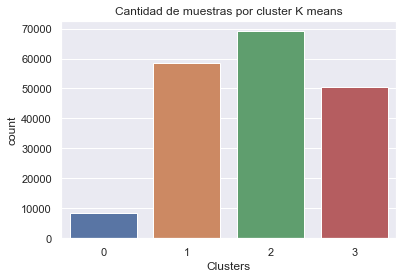

In [48]:
sns.countplot(kmeans.labels_)
plt.title("Cantidad de muestras por cluster K means")
plt.xlabel("Clusters")
plt.show()

In [49]:
rand_index = metrics.adjusted_rand_score(delitos_total['gravedad'], kmeans.labels_)

In [50]:
sil_score = metrics.silhouette_score(xscal, kmeans.labels_, metric='sqeuclidean')

In [51]:
results_cluster = pd.DataFrame(columns=['Cluster','Rand_','Sil_'])

In [52]:
results_cluster = results_cluster.append({'Cluster':'Kmeans',
                                'Rand_':rand_index,
                                'Sil_':sil_score},ignore_index=True)
results_cluster

,Cluster,Rand_,Sil_
0,Kmeans,0.933986,0.462344


In [53]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = x.index.values
cluster_map['cluster'] = kmeans.labels_
cluster_map['latitud'] = delitos_cluster['latitud']
cluster_map['longitud'] = delitos_cluster['longitud']
cluster_map = cluster_map.set_index('data_index')
x_clusterizado = x.merge(cluster_map, left_on = x.index, right_on = cluster_map.index)
x_clusterizado.barrio = round(x_clusterizado.barrio,1) 
x_clusterizado.head()

,key_0,franja_horaria,barrio,poblacion,delitos_barrio,densidad_delitos,cluster,latitud,longitud
0,0,11,24,40985,3216,0.078468,1,-34.636791,-58.403786
1,1,8,27,157932,8750,0.055404,2,-34.592514,-58.404175
2,2,15,8,27761,2451,0.088289,1,-34.590628,-58.448602
3,3,2,23,17489,756,0.043227,1,-34.588924,-58.478135
4,4,2,23,17489,756,0.043227,1,-34.588848,-58.484470


In [54]:
cluster_0 = x_clusterizado.loc[x_clusterizado.cluster == 0]
cluster_1 = x_clusterizado.loc[x_clusterizado.cluster == 1]
cluster_2 = x_clusterizado.loc[x_clusterizado.cluster == 2]
cluster_3 = x_clusterizado.loc[x_clusterizado.cluster == 3]
print(np.shape(cluster_0), np.shape(cluster_1), np.shape(cluster_2), np.shape(cluster_3))

(8342, 9) (58489, 9) (69110, 9) (50503, 9)


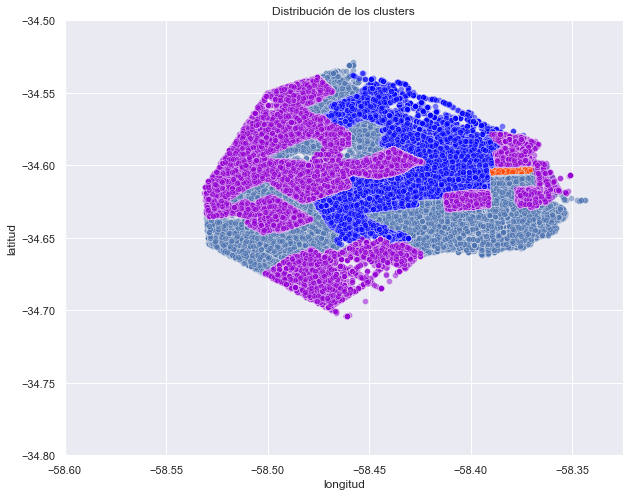

In [55]:
plt.figure(figsize = (10,8))
plt.axis([ -58.6, -58.325, -34.8, -34.5000])
sns.scatterplot(cluster_0.longitud,cluster_0.latitud, alpha=0.5, color = 'orangered')
sns.scatterplot(cluster_1.longitud,cluster_1.latitud, alpha=0.5, color = 'b')
sns.scatterplot(cluster_2.longitud,cluster_2.latitud, alpha=0.5, color = 'blue')
sns.scatterplot(cluster_3.longitud,cluster_3.latitud, alpha=0.5, color = 'darkviolet')
plt.title('Distribución de los clusters')
plt.show()

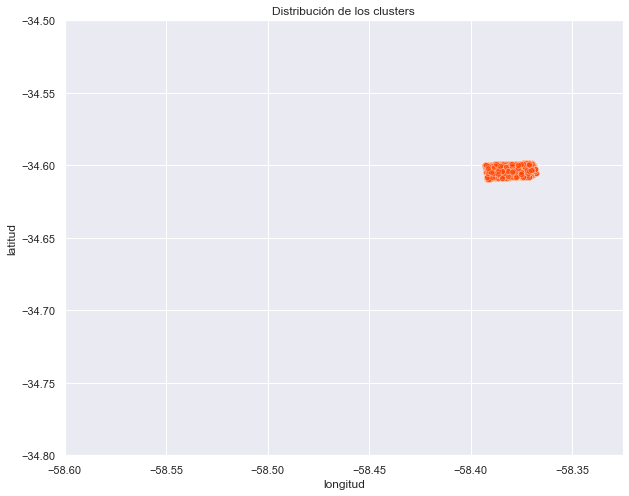

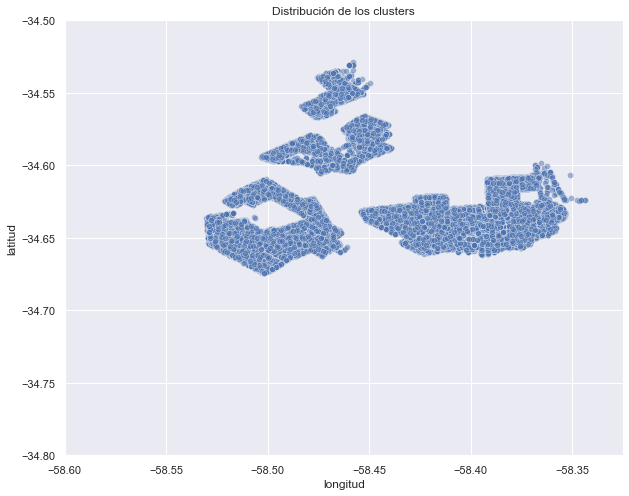

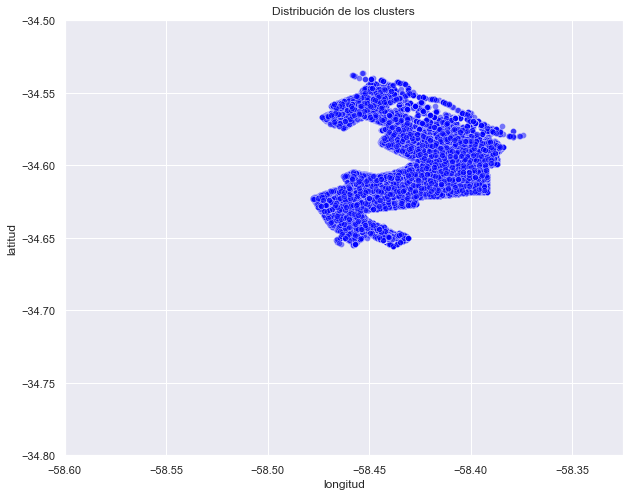

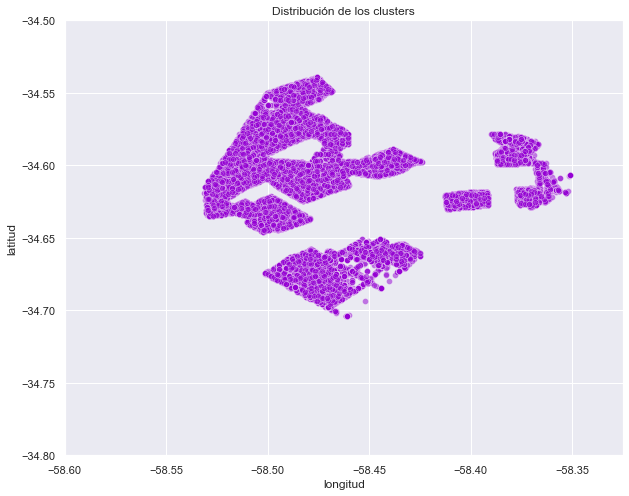

In [56]:
plt.figure(figsize = (10,8))
plt.axis([ -58.6, -58.325, -34.8, -34.5000])
sns.scatterplot(cluster_0.longitud,cluster_0.latitud, alpha=0.5, color = 'orangered')
plt.title('Distribución de los clusters')
plt.show()

plt.figure(figsize = (10,8))
plt.axis([ -58.6, -58.325, -34.8, -34.5000])
sns.scatterplot(cluster_1.longitud,cluster_1.latitud, alpha=0.5, color = 'b')
plt.title('Distribución de los clusters')
plt.show()

plt.figure(figsize = (10,8))
plt.axis([ -58.6, -58.325, -34.8, -34.5000])
sns.scatterplot(cluster_2.longitud,cluster_2.latitud, alpha=0.5, color = 'blue')
plt.title('Distribución de los clusters')
plt.show()

plt.figure(figsize = (10,8))
plt.axis([ -58.6, -58.325, -34.8, -34.5000])
sns.scatterplot(cluster_3.longitud,cluster_3.latitud, alpha=0.5, color = 'darkviolet')
plt.title('Distribución de los clusters')
plt.show()

In [57]:
table = pd.pivot_table(
    #datframe
    x_clusterizado,
    # Filas
    index='cluster',
    # Columnas
    columns = 'franja_horaria',
    # Quiero ver los log_precios
    values='key_0' ,
    # si hay NaN, pongo un cero 
    fill_value=0,
    # Que funcion aplico?
    aggfunc = 'count')
table

franja_horaria,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cluster,,,,,,,,,,,,,,,,,,,,,
0,625,98,72,60,81,103,92,166,320,430,...,582,474,471,507,608,488,420,346,275,201
1,3781,1203,946,809,864,1204,1580,2059,2804,2655,...,2993,2819,2863,2986,3166,3330,3226,2822,2593,2147
2,4639,1418,1068,1014,1017,1185,1416,1783,2487,2617,...,3733,3615,3958,3878,4370,4269,4049,3577,2850,2363
3,3121,960,752,663,617,916,1215,1589,2195,2217,...,2546,2614,2641,2673,2892,2909,3070,2709,2372,1891


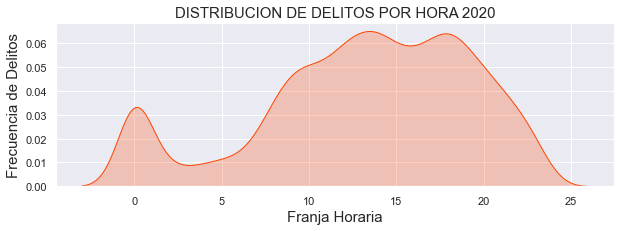

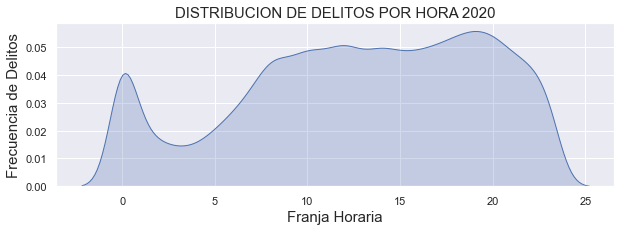

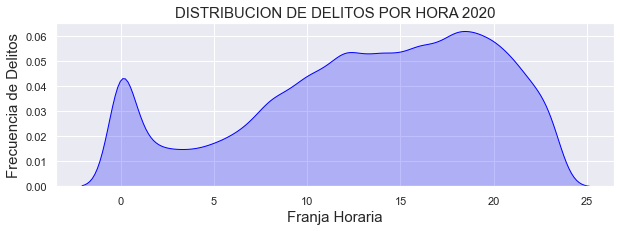

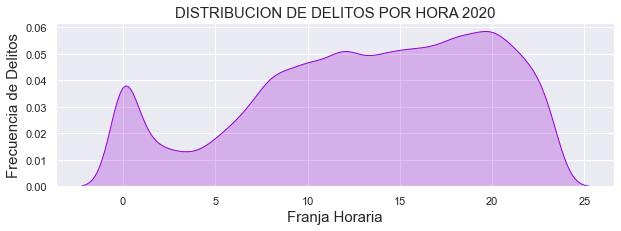

In [58]:
plt.figure(figsize=(10,3))
sns.kdeplot(cluster_0['franja_horaria'], color= "orangered", shade = True)
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Frecuencia de Delitos",size = 15)
plt.title('DISTRIBUCION DE DELITOS POR HORA 2020',size = 15)
plt.show()

plt.figure(figsize=(10,3))
sns.kdeplot(cluster_1['franja_horaria'], color= "b", shade = True)
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Frecuencia de Delitos",size = 15)
plt.title('DISTRIBUCION DE DELITOS POR HORA 2020',size = 15)
plt.show()

plt.figure(figsize=(10,3))
sns.kdeplot(cluster_2['franja_horaria'], color= "blue", shade = True)
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Frecuencia de Delitos",size = 15)
plt.title('DISTRIBUCION DE DELITOS POR HORA 2020',size = 15)
plt.show()

plt.figure(figsize=(10,3))
sns.kdeplot(cluster_3['franja_horaria'], color= "darkviolet", shade = True)
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Frecuencia de Delitos",size = 15)
plt.title('DISTRIBUCION DE DELITOS POR HORA 2020',size = 15)
plt.show()

## Clustering con PCA + Kmeans

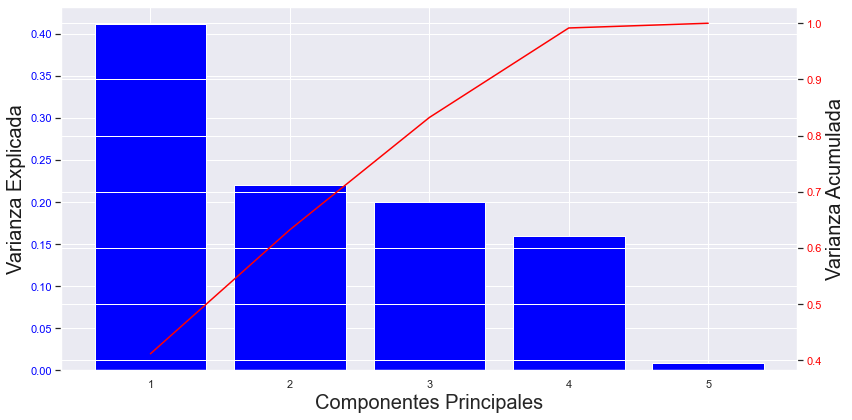

In [59]:
# Definimos la cantidad de componentes
n_comps = 5
components = range(1,n_comps + 1)
#Creamos el objeto PCA
pca = PCA(n_components=n_comps)

# Ajustamos
pca.fit(xscal)
# Transformamos
xpca = pca.transform(xscal)

# Porcentaje de la varianza explicada por cada Principal Component (PC)
eigenvalues = pca.explained_variance_ratio_

# Suma acumulada
eigenvalues_acum = pca.explained_variance_ratio_.cumsum() 

# Graficamos
# Eje Izquierdo
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Componentes Principales',fontsize=20)
ax1.set_ylabel('Varianza Explicada', color='k',fontsize=20)
ax1.bar(components, eigenvalues, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Eje derecho
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Varianza Acumulada', color='k',fontsize=20) 
ax2.plot(components, eigenvalues_acum, color='red') 
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [60]:
# Cantidad de PC quer queremos
reduced_dim = 2
# Definimos nuetro nuevo X de dimension reducida
xpca_rd = xpca[:,0:reduced_dim]

In [61]:
# Generamos el modelo PCA + K-means
kmeans_rd = KMeans(n_clusters=4, 
                   random_state=10).fit(xpca_rd)

In [62]:
# visualizamos los centroides finales de cada cluster
centers_rd = kmeans_rd.cluster_centers_
centers_rd

array([[ 2.41315106,  0.38629447],
       [-1.06608927, -0.24762768],
       [-1.08152582,  4.18462571],
       [ 1.04778391, -0.4473144 ]])

In [63]:
rand_index1 = metrics.adjusted_rand_score(delitos_total['gravedad'], kmeans_rd.labels_)

In [64]:
sil_score1 = metrics.silhouette_score(xpca, kmeans.labels_, metric='sqeuclidean')

In [65]:
results_cluster = results_cluster.append({'Cluster':'2PC + Kmeans',
                                'Rand_':rand_index1,
                                'Sil_':sil_score1},ignore_index=True)
results_cluster

,Cluster,Rand_,Sil_
0,Kmeans,0.933986,0.462344
1,2PC + Kmeans,0.497951,0.462344


En conclusión, nuestro objetivo principal fue determinar que las diversas clusterizaciones implementadas permitan agrupar los clusters por algún tipo de analogía con los diferentes tipos de delitos y su gravedad correspondiente. Podemos observar que al aplicar PCA el rand score baja pero el silhoutte mantiene el mismo valor, lo que nos determina que el cluster sin aplicar PCA muestra mayor similitud con la clasificación de los diferentes tipos de delitos, por lo que, definimos que el mejor método entre los que aplicamos es la clusterización mediante el método de kmeans.  